# Importing Libraries and Dataset

In [153]:
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt

from sklearn import metrics as skmetrics
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from bayes_opt import BayesianOptimization
import shap

In [154]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

In [174]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

# Evaluation Metrics Function

In [156]:
def print_statistics(y_actual, y_pred, y_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision (macro): {round(skmetrics.precision_score(y_actual, y_pred, average='macro'),5)}")
  print(f"recall (macro): {round(skmetrics.recall_score(y_actual, y_pred, average='macro'),5)}")
  print(f"f1 score (macro): {round(skmetrics.f1_score(y_actual, y_pred, average='macro'),5)}")
  print(f"f1 score of class 1: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=1),5)}")
  print(f"f1 score of class 0: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=0),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob)
  print(f"pr auc score of class 1: {round(skmetrics.auc(recall, prec),5)}")
  prec_0, recall_0, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob, pos_label=0)
  print(f"pr auc score of class 0: {round(skmetrics.auc(recall_0, prec_0),5)}")

# Fitting XGBoost model

In [175]:
xgb_model = xgb.XGBClassifier().fit(X_smote, y_smote)

In [176]:
train_pred_xgb = xgb_model.predict(X_smote)
train_pred_xgb_prob = xgb_model.predict_proba(X_smote)[:,1]
val_pred_xgb = xgb_model.predict(X_val)
val_pred_xgb_prob = xgb_model.predict_proba(X_val)[:,1]
test_pred_xgb = xgb_model.predict(X_test)
test_pred_xgb_prob = xgb_model.predict_proba(X_test)[:,1]
print_statistics(y_smote, train_pred_xgb, train_pred_xgb_prob, 'train')
print_statistics(y_val, val_pred_xgb, val_pred_xgb_prob, 'val')
print_statistics(y_test, test_pred_xgb, test_pred_xgb_prob, 'test')

=====================train====================
accuracy: 0.96056
precision (macro): 0.96366
recall (macro): 0.94386
f1 score (macro): 0.95296
f1 score of class 1: 0.93405
f1 score of class 0: 0.97187
pr auc score of class 1: 0.99332
pr auc score of class 0: 0.47363
=====================val====================
accuracy: 0.94105
precision (macro): 0.94361
recall (macro): 0.90504
f1 score (macro): 0.92198
f1 score of class 1: 0.8834
f1 score of class 0: 0.96056
pr auc score of class 1: 0.86938
pr auc score of class 0: 0.53676
=====================test====================
accuracy: 0.9414
precision (macro): 0.94075
recall (macro): 0.90851
f1 score (macro): 0.92296
f1 score of class 1: 0.88527
f1 score of class 0: 0.96065
pr auc score of class 1: 0.86564
pr auc score of class 0: 0.53442


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

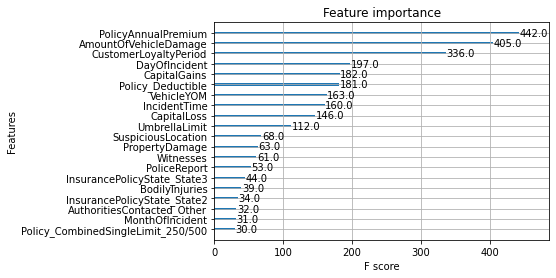

In [177]:
# Top 20 Most Important Features in XGB
xgb.plot_importance(xgb_model, max_num_features=20)

# Choosing the top 60 features

In [207]:
thresholds = sort(xgb_model.feature_importances_)
thres = thresholds[-60]

selection = SelectFromModel(xgb_model, threshold=thres, prefit=True)
select_X_train = selection.transform(X_smote.to_numpy())

# train model
selection_model = xgb.XGBClassifier()
selection_model.fit(select_X_train, y_smote)

# eval model
select_X_val = selection.transform(X_val.to_numpy())
y_pred = selection_model.predict_proba(select_X_val)[:,1]
predictions = selection_model.predict(select_X_val)
print_statistics(y_val, predictions, y_pred, 'Val: Threshold={}, n={}'.format(thres, select_X_train.shape[1]))

=====================Val: Threshold=0.002981129800900817, n=60====================
accuracy: 0.94175
precision (macro): 0.94504
recall (macro): 0.90551
f1 score (macro): 0.92283
f1 score of class 1: 0.88462
f1 score of class 0: 0.96104
pr auc score of class 1: 0.86229
pr auc score of class 0: 0.53675


In [210]:
# Getting selected features for x test
select_X_test = selection.transform(X_test.to_numpy())
y_pred = selection_model.predict_proba(select_X_test)[:,1]
predictions = selection_model.predict(select_X_test)
print_statistics(y_test, predictions, y_pred, 'Test: Threshold={}, n={}'.format(thres, select_X_train.shape[1]))

=====================Test: Threshold=0.002981129800900817, n=60====================
accuracy: 0.94244
precision (macro): 0.94282
recall (macro): 0.90922
f1 score (macro): 0.92423
f1 score of class 1: 0.88707
f1 score of class 0: 0.96138
pr auc score of class 1: 0.85347
pr auc score of class 0: 0.53608


In [211]:
feature_idx = selection.get_support()
feature_names = X_smote.columns[feature_idx]
df_select_X_test = pd.DataFrame(select_X_test, columns=feature_names)

explainer = shap.TreeExplainer(selection_model, df_select_X_test)
shap_values = explainer(df_select_X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


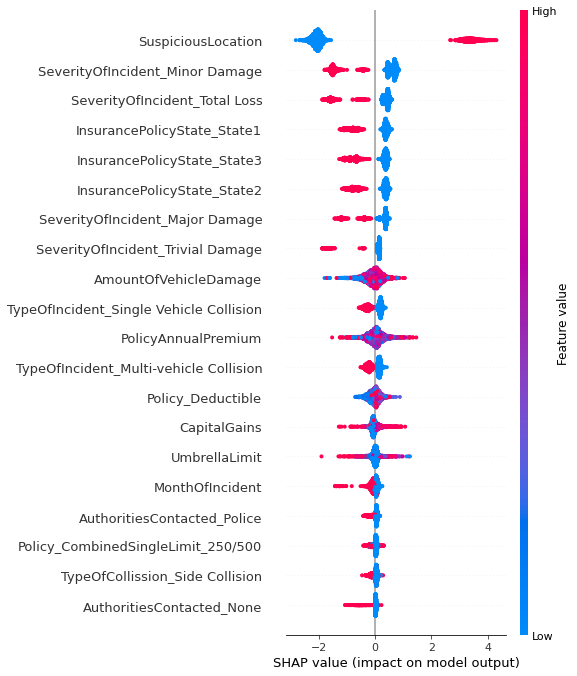

In [212]:
shap.summary_plot(shap_values, features=df_select_X_test)

From the SHAP summary plot,
- suspicious location is one of the most important indicator of determining fraud. If the insurance claim location occurs in a suspicious location, there is a higher probabilty of the claim being fraud.
- The severity of incident is also an important indicator of determining fraud. If the incident only has minor damage, then the chances of it being fraud is smaller.

# Hyperparameter Tuning using Bayesian Optimization

In [213]:
seed = 1

def xgbc_func(max_depth,learning_rate,n_estimators,reg_alpha):
    
    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    # Fit the estimator
    estimator_function.fit(select_X_train, y_smote)
    probs = estimator_function.predict_proba(select_X_val)
    probs = probs[:,1]
    pred = estimator_function.predict(select_X_val)
    # prec, recall, thresholds = skmetrics.precision_recall_curve(y_val, probs)
    # val_prauc = skmetrics.auc(recall, prec)
    val_acc = skmetrics.accuracy_score(y_val, pred)
    # val_prec = skmetrics.precision_score(y_val, pred, average='macro')
    # val_recall = skmetrics.recall_score(y_val, pred, average='macro')
    # val_f1 = skmetrics.f1_score(y_val, pred, average='macro')
    
    return val_acc

In [214]:
gp_params = {"alpha": 1e-10}

hyperparameter_space = {
    'max_depth': (1, 100),
    'learning_rate': (0, 1),
    'n_estimators' : (10,500),
    'reg_alpha': (0,1),
}

xgbcBO = BayesianOptimization(f = xgbc_func, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

In [215]:
xgbcBO.maximize(init_points=3, n_iter=20, **gp_params)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
| 1         | 0.9407    | 0.417     | 72.31     | 10.06     | 0.3023    |
| 2         | 0.9414    | 0.1468    | 10.14     | 101.3     | 0.3456    |
| 3         | 0.9359    | 0.3968    | 54.34     | 215.4     | 0.6852    |
| 4         | 0.9317    | 0.9661    | 11.23     | 100.5     | 0.5994    |
| 5         | 0.9348    | 0.4426    | 41.93     | 278.4     | 0.7442    |
| 6         | 0.9327    | 0.6234    | 23.1      | 480.0     | 0.8047    |
| 7         | 0.9397    | 0.02121   | 80.98     | 482.8     | 0.7021    |
| 8         | 0.9421    | 0.3644    | 3.217     | 84.68     | 0.9715    |
| 9         | 0.9258    | 0.9953    | 33.19     | 410.3     | 0.04463   |
| 10        | 0.9317    | 0.9812    | 27.77     | 406.3     | 0.4466    |
| 11        | 0.9355    | 0.3249    | 63.94     | 206.2     | 0.7516    |
| 12        | 0.9348    | 0.3059    | 

In [216]:
# Best Hyperparameters selected
xgbcBO.max

{'target': 0.9420943134535368,
 'params': {'learning_rate': 0.3644191915674285,
  'max_depth': 3.21741300222239,
  'n_estimators': 84.68302963640717,
  'reg_alpha': 0.9715215238815028}}

In [217]:
xgb_tuned_model = xgb.XGBClassifier(max_depth=int(xgbcBO.max['params']['max_depth']),
                                           n_estimators= int(xgbcBO.max['params']['n_estimators']),
                                           reg_alpha = xgbcBO.max['params']['reg_alpha'],
                                           learning_rate = xgbcBO.max['params']['learning_rate'],
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = 1,
                                           booster='gbtree')

xgb_tuned_model.fit(select_X_train, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3644191915674285,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=84,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [218]:
train_pred_xgb_tuned = xgb_tuned_model.predict(select_X_train)
train_pred_xgb_tuned_prob = xgb_tuned_model.predict_proba(select_X_train)[:,1]
val_pred_xgb_tuned = xgb_tuned_model.predict(select_X_val)
val_pred_xgb_tuned_prob = xgb_tuned_model.predict_proba(select_X_val)[:,1]
test_pred_xgb_tuned = xgb_tuned_model.predict(select_X_test)
test_pred_tuned_prob = xgb_tuned_model.predict_proba(select_X_test)[:,1]
print_statistics(y_smote, train_pred_xgb_tuned, train_pred_xgb_tuned_prob, 'train')
print_statistics(y_val, val_pred_xgb_tuned, val_pred_xgb_tuned_prob, 'val')
print_statistics(y_test, test_pred_xgb_tuned, test_pred_tuned_prob, 'test')

=====================train====================
accuracy: 0.94463
precision (macro): 0.94681
recall (macro): 0.92284
f1 score (macro): 0.93361
f1 score of class 1: 0.90655
f1 score of class 0: 0.96066
pr auc score of class 1: 0.94543
pr auc score of class 0: 0.47985
=====================val====================
accuracy: 0.94209
precision (macro): 0.94529
recall (macro): 0.90615
f1 score (macro): 0.92332
f1 score of class 1: 0.88538
f1 score of class 0: 0.96126
pr auc score of class 1: 0.87513
pr auc score of class 0: 0.53333
=====================test====================
accuracy: 0.94313
precision (macro): 0.94378
recall (macro): 0.9101
f1 score (macro): 0.92514
f1 score of class 1: 0.88844
f1 score of class 0: 0.96184
pr auc score of class 1: 0.85432
pr auc score of class 0: 0.53565
